In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('store.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [2]:
store_daily_sales = data.groupby(['date', 'store']).agg({'sales': 'sum'}).reset_index()
store_daily_sales_1 = store_daily_sales[store_daily_sales['store'] == 1]
store_daily_sales_1 = store_daily_sales_1.set_index('date')
store_daily_sales_1

,store,sales
date,,
2013-01-01,1,1316
2013-01-02,1,1264
2013-01-03,1,1305
2013-01-04,1,1452
2013-01-05,1,1499
...,...,...
2017-12-27,1,1837
2017-12-28,1,1951
2017-12-29,1,2116


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sales_data = store_daily_sales_1['sales'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales_data)

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_sales, seq_length)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer= 'adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                               
y_pred = model.predict(X_test)

# Chuyển đổi giá trị dự đoán về thang đo ban đầu
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/50
180/180 [==============================] - 14s 37ms/step - loss: 0.0195 - val_loss: 0.0147
Epoch 2/50
180/180 [==============================] - 5s 27ms/step - loss: 0.0139 - val_loss: 0.0178
Epoch 3/50
180/180 [==============================] - 5s 27ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4/50
180/180 [==============================] - 5s 26ms/step - loss: 0.0132 - val_loss: 0.0144
Epoch 5/50
180/180 [==============================] - 5s 26ms/step - loss: 0.0129 - val_loss: 0.0152
Epoch 6/50
180/180 [==============================] - 5s 26ms/step - loss: 0.0130 - val_loss: 0.0145
Epoch 7/50
180/180 [==============================] - 5s 26ms/step - loss: 0.0128 - val_loss: 0.0161
Epoch 8/50
180/180 [==============================] - 5s 26ms/step - loss: 0.0124 - val_loss: 0.0148
Epoch 9/50
180/180 [==============================] - 5s 28ms/step - loss: 0.0127 - val_loss: 0.0140
Epoch 10/50
180/180 [==============================] - 5s 26ms/step - loss: 0.0123 - val_l

In [4]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 138.6633949857352
MAE: 96.67972276475695


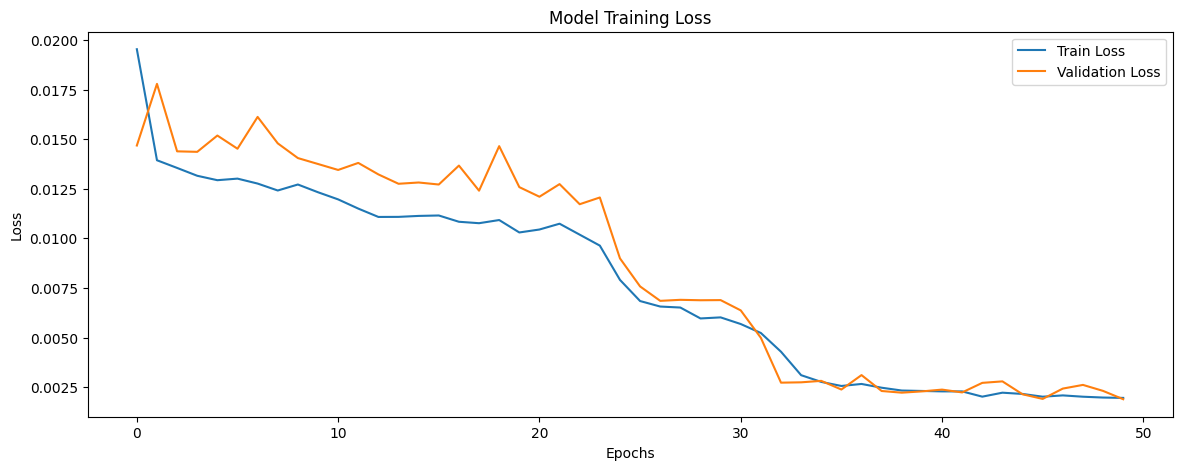

In [5]:
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 40ms/step


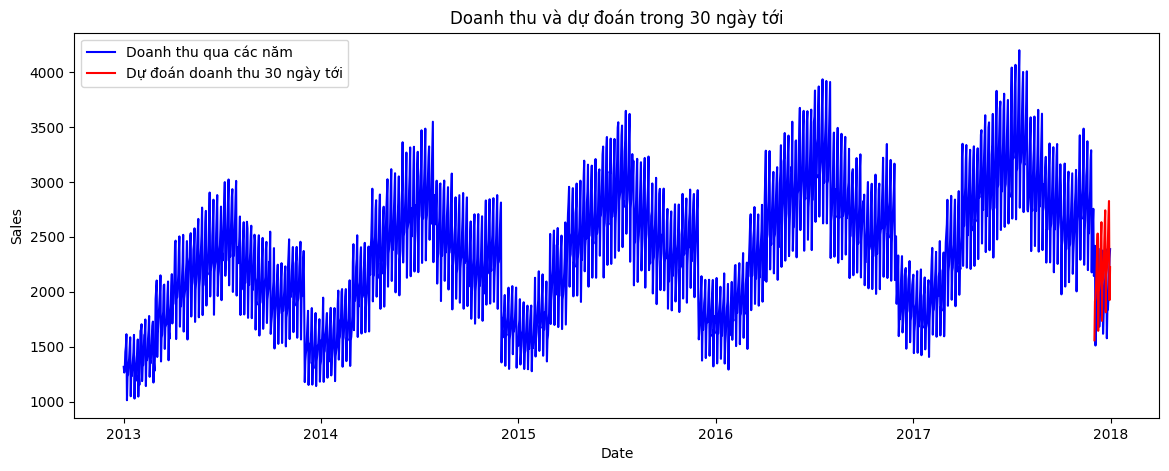

In [7]:
import matplotlib.dates as mdates

last_sequence = scaled_sales[-seq_length:]
predictions = []

for _ in range(30):
    # Dự đoán giá trị tiếp theo
    input_data = last_sequence.reshape((1, seq_length, 1))
    next_pred = model.predict(input_data)
    # Lưu dự đoán
    predictions.append(next_pred[0, 0])
    # Cập nhật chuỗi đầu vào cho lần dự đoán tiếp theo
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

# Chuyển đổi các giá trị dự đoán về thang đo ban đầu
predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

#predicted_dates = pd.date_range(start=data.index[-1], periods=len(predictions_rescaled) + 1, inclusive='right')

plt.figure(figsize=(14, 5))
plt.plot(store_daily_sales_1.index, sales_data, color='blue', label='Doanh thu qua các năm')
plt.plot(store_daily_sales_1.index[-30:], predictions_rescaled, color='red', label='Dự đoán doanh thu 30 ngày tới')
plt.title('Doanh thu và dự đoán trong 30 ngày tới')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()